# Laboratorio 4
## Universidad del Valle de Guatemala <br> Facultad de Ingeniería
#### Departamento de Ciencias de la Computación <br> Data Science - Sección 10 <br> Grupo 12
#### Cristian Laynez

In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import joblib as jl
import nltk
import re
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
from nltk import bigrams
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [5]:
from textblob import TextBlob
from afinn import Afinn

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words('english'))

#### 2. Cargar el archivo de datos.

In [10]:
# 1. Ya se descargo el archivo train.csv
data_frame = pd.read_csv('./data/train.csv')
data_frame

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Se puede apreciar que se tienen las siguientes variables junto con su descripción y estado:

- id: Este sería el identificador del texto
- keyword: Palabra clave de como "catagolaron" el tweet
- location: El lugar en donde se publico el tewt
- text: El texto del mismo tweet publicado
- target: Clasificacion del tweet si es un desastre real o no

Se puede apreciar que se pueden encontrar datos vacios en keyword y en location.

#### 3. Limpie y preprocese los datos (Describir de forma detallada las actividades de preprocesamiento que se llevó a cabo)

In [11]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [12]:
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [13]:
def get_stemmed_text(text):    
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [14]:
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [15]:
# Convertir el texto en minúsculas
data_frame['text'] = data_frame['text'].str.lower()

# Quitar caracteres especiales “#”,”@” o los apóstrofes
data_frame['text'] = data_frame['text'].str.replace(r'[#@\'"]', '', regex=True)

# Quitar urls
data_frame['text'] = data_frame['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)

# Eliminar signos de puntuacion
data_frame['text'] = data_frame['text'].str.replace(r'[^\w\s]', '', regex=True)

In [16]:
# Revisar si hay emojis en el texto y luego quitarlos
data_frame['text'] = data_frame['text'].apply(remove_emojis)

In [17]:
# Quitar los artículos, preposiciones y conjunciones (stopwords)
data_frame['text'] = data_frame['text'].apply(remove_stopwords)

In [18]:
# Normalizar las palabras para tratar de convertir todas las palabras encontradas en solo una palabra
data_frame['text'] = data_frame['text'].apply(get_stemmed_text)

In [19]:
# Aplicar la función de lematización al atributo 'text' para identificar la parte
# del discurso de una palabra determinada y luego aplicando reglas más complejas 
# para transformar la palabra en su verdadera raíz
data_frame['text'] = data_frame['text'].apply(apply_lemmatization)

In [20]:
data_frame

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv u,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,13000 peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane hold bridg collaps nearbi home,1
7609,10870,NaN,NaN,aria_ahrari thetawniest control wild fire cali...,1
7610,10871,NaN,NaN,m194 0104 utc5km volcano hawaii,1
7611,10872,NaN,NaN,polic investig ebik collid car littl portug eb...,1


Como se podrá observar se opto por quitar convertir todo el te xto en minusculas, en quitar caracteres especiales, removemoer urls, eliminar signos de puntuacion extraños, luego quitar todos los emojis y luego remover los "stopwords" el cual en consecuencia nos permite tener data mejor procesada. Se tomara en cuetna el tipo de keywrod y location que tiene para apoyarnos en detectar las palabras usadas con más frecuencia y aparte detectar si en efecto se hablan de desastres reales o no.

#### 4. Obtener frecuencia de las palabras tanto de los tweets de desastres como de los que no.

In [21]:
# Separar los tweets de desastres y los que no lo son
disasters_tweets = data_frame[data_frame['target'] == 1]['text']
no_disasters_tweets = data_frame[data_frame['target'] == 0]['text']

# Tokenizar los tweets
tokens_disasters = word_tokenize(' '.join(disasters_tweets))
tokens_no_disasters = word_tokenize(' '.join(no_disasters_tweets))

# Calcular la frecuencia de las palabras
freq_disasters = FreqDist(tokens_disasters)
freq_no_disasters = FreqDist(tokens_no_disasters)

In [22]:
# Imprimir las palabras más comunes
print('Palabras más comunes en tweets de desastres:')
for word, frequency in freq_disasters.most_common(20):
    print(f'{word}: {frequency}')

Palabras más comunes en tweets de desastres:
fire: 267
bomb: 180
kill: 158
news: 136
via: 121
flood: 120
disast: 117
california: 115
crash: 112
suicid: 110
train: 109
polic: 107
peopl: 106
amp: 106
famili: 105
u: 104
attack: 104
evacu: 101
like: 101
home: 100


In [23]:
print('\nPalabras más comunes en tweets que no son de desastres:')
for word, frequency in freq_no_disasters.most_common(20):
    print(f'{word}: {frequency}')


Palabras más comunes en tweets que no son de desastres:
like: 307
im: 244
get: 223
amp: 192
new: 168
u: 142
go: 142
dont: 141
one: 135
love: 116
bodi: 116
bag: 109
time: 104
video: 102
via: 99
want: 98
see: 98
scream: 98
would: 97
make: 97


##### ¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación?

Caso de tweets de desastres:
- fire
- bomb
- kill
- news
- suicide
- police
- flood
- disast
- amp
- attack
- crash
- polic
- evacu

En lo personal creo que estas serian las mejores palabras para clasificar un desastre real ya que estos tocan temas serios.

Caso de tweets de no desastres:
- like
- get
- amp
- go
- dont
- one
- love
- bodi
- time
- video
- via
- want
- see
- would

Para el caso de los no desastres considero que estas palabras serían mejores para clasificar los temas de ironia y comedia, ya que como se puede apreciar son palabras haciendo referencia a una persona, a algunos temas agradables e inclusive hablando sobre "que pasaría".

##### ¿Vale la pena explorar bigramas o trigramas para analizar contexto?

##### Vamos a obtener y crear los bigramas

In [24]:
# Crear bigramas
bigrams_disasters = list(bigrams(tokens_disasters))
bigrams_no_disasters = list(bigrams(tokens_no_disasters))

# Calcular la frecuencia de los bigramas
freq_bigrams_disasters = FreqDist(bigrams_disasters)
freq_bigrams_no_disasters = FreqDist(bigrams_no_disasters)

In [25]:
# Imprimir los bigramas más comunes
print('Bigramas más comunes en tweets de desastres:')
for word, frequency in freq_bigrams_disasters.most_common(15):
    print(f'{word}: {frequency}')

Bigramas más comunes en tweets de desastres:
('suicid', 'bomber'): 60
('atom', 'bomb'): 50
('train', 'derail'): 49
('mass', 'murder'): 45
('northern', 'california'): 41
('oil', 'spill'): 38
('suicid', 'bomb'): 36
('california', 'wildfir'): 36
('burn', 'build'): 35
('bomber', 'deton'): 31
('70', 'year'): 30
('confirm', 'mh370'): 29
('deton', 'bomb'): 29
('home', 'raze'): 29
('sever', 'thunderstorm'): 28


In [26]:
print('\nBigramas más comunes en tweets que no son de desastres:')
for word, frequency in freq_bigrams_no_disasters.most_common(15):
    print(f'{word}: {frequency}')


Bigramas más comunes en tweets que no son de desastres:
('bodi', 'bag'): 70
('cross', 'bodi'): 38
('look', 'like'): 36
('youtub', 'video'): 36
('like', 'youtub'): 35
('gon', 'na'): 32
('wan', 'na'): 30
('feel', 'like'): 27
('full', 'reû_'): 25
('burn', 'build'): 23
('full', 'read'): 22
('reddit', 'quarantin'): 21
('content', 'polici'): 20
('emerg', 'servic'): 18
('via', 'youtub'): 18


##### Ahora vamos a crear trigramas para analizar los diferentes contextos, se utilizaran 3 n-gramas para calcular los trigramas.

In [27]:
# Crear trigramas
trigrams_disasters = list(ngrams(tokens_disasters, 3))
trigrams_no_disasters = list(ngrams(tokens_no_disasters, 3))

# Calcular la frecuencia de los trigramas
freq_trigrams_disasters = FreqDist(trigrams_disasters)
freq_trigrams_no_disasters = FreqDist(trigrams_no_disasters)

In [28]:
# Imprimir los trigramas más comunes
print('Trigramas más comunes en tweets de desastres:')
for word, frequency in freq_trigrams_disasters.most_common(15):
    print(f'{word}: {frequency}')

Trigramas más comunes en tweets de desastres:
('suicid', 'bomber', 'deton'): 31
('northern', 'california', 'wildfir'): 29
('latest', 'home', 'raze'): 28
('home', 'raze', 'northern'): 28
('pkk', 'suicid', 'bomber'): 28
('bomber', 'deton', 'bomb'): 28
('raze', 'northern', 'california'): 27
('16yr', 'old', 'pkk'): 27
('old', 'pkk', 'suicid'): 27
('famili', 'sue', 'legionnair'): 26
('40', 'famili', 'affect'): 26
('famili', 'affect', 'fatal'): 26
('affect', 'fatal', 'outbreak'): 26
('obama', 'declar', 'disast'): 25
('declar', 'disast', 'typhoondevast'): 25


In [29]:
print('\nTrigramas más comunes en tweets que no son de desastres:')
for word, frequency in freq_trigrams_no_disasters.most_common(15):
    print(f'{word}: {frequency}')


Trigramas más comunes en tweets que no son de desastres:
('like', 'youtub', 'video'): 35
('cross', 'bodi', 'bag'): 22
('reddit', 'quarantin', 'offens'): 18
('quarantin', 'offens', 'content'): 18
('pick', 'fan', 'armi'): 17
('reddit', 'new', 'content'): 16
('new', 'content', 'polici'): 16
('stock', 'market', 'crash'): 16
('full', 'read', 'ebay'): 15
('ignit', 'knock', 'deton'): 15
('content', 'polici', 'goe'): 15
('polici', 'goe', 'effect'): 15
('goe', 'effect', 'mani'): 15
('effect', 'mani', 'horribl'): 15
('mani', 'horribl', 'subreddit'): 15


En base a los resultados obtenidos se puede apreciar que vale más la pena utilizar los trigramas ya que estos suelen dar mucho más contexto que los bigramas, los bigramas algunos de sus resultados pueden dejar muy ambiguos el contexto y se puede interpretar de formas muy diferentes. Sin emmbargo con los trigramas se combinan palabras más serias y dan más contexto ya sea un desastre real o no.

##### Modelo de predicción

Para este escenario se creara un modelo de predicción con la ayuda y el apoyo del algoritmo SVM (Support Vector Machines)

In [30]:
# Crear el vectorizador
ngram_vectorizer = CountVectorizer(
    binary=True, 
    ngram_range=(1, 3), 
    stop_words='english'
)

# Aplicar el vectorizador a los datos de texto
X = ngram_vectorizer.fit_transform(data_frame['text'])

# Definir la variable objetivo
y = data_frame['target']

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.75)

# Entrenar el modelo SVM con diferentes valores de C y seleccionar el que da la mejor precisión
best_accuracy = 0
best_c = None
for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    accuracy = accuracy_score(y_val, svm.predict(X_val))
    print ("Accuracy for C=%s: %s" % (c, accuracy))
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_c = c

model_svm = LinearSVC(C=best_c).fit(X, y)

d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Programs\Python\Python311\Lib\site-packag

Accuracy for C=0.001: 0.7326680672268907
Accuracy for C=0.005: 0.7899159663865546
Accuracy for C=0.01: 0.7951680672268907
Accuracy for C=0.05: 0.7993697478991597
Accuracy for C=0.1: 0.8019957983193278


d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [31]:
# Entrenar el modelo final con el mejor valor de C y calcular la precisión final
final_svm = LinearSVC(C=0.01)
final_svm.fit(X, y)
print ("Final Accuracy: %s" % accuracy_score(y, final_svm.predict(X)))

d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Final Accuracy: 0.9323525548404046


Como se puede apreciar al final se logro obtener un accurracy de 0.93, el cual es un resultado excelente y sobresaliente, esto fue gracias al preprocesamiento realizado en el texto con anterioridad. Gracias a la combinación de las técnicas anteriores se logro obtener un modelo capaz de realizar predicciones muy acertadas y eficaces.

#### 5. Realizar un análisis exploratorio de los datos para entrenderlos mejor, documente todos los análisis.

#### => Investigar qué palabra se repite más en cada una de las categorías

In [32]:
# Calcular la frecuencia de las palabras para los tweets de desastres
freq_disasters = FreqDist(word_tokenize(' '.join(data_frame[data_frame['target'] == 1]['text'])))

# Calcular la frecuencia de las palabras para los tweets que no son de desastres
freq_no_disasters = FreqDist(word_tokenize(' '.join(data_frame[data_frame['target'] == 0]['text'])))

# Imprimir la palabra más común para cada categoría
print('Palabra más común en tweets de desastres:', freq_disasters.most_common(1))
print('Palabra más común en tweets que no son de desastres:', freq_no_disasters.most_common(1))

Palabra más común en tweets de desastres: [('fire', 267)]
Palabra más común en tweets que no son de desastres: [('like', 307)]


#### => Hacer una nube de palabras para visualizar las que aparecen con más frecuencia

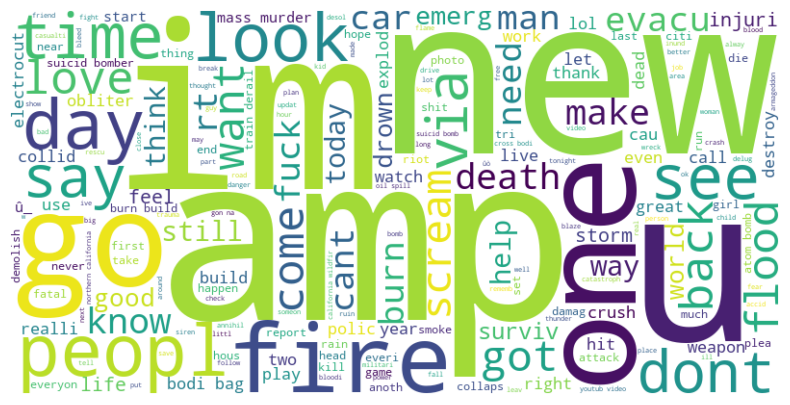

In [33]:
# Combina todos los textos en uno solo (si tus textos están en una lista)
combined_text = ' '.join(data_frame["text"])

# Configura la nube de palabras
wordcloud = WordCloud(
    background_color='white',  # Color del fondo
    width=800, height=400,     # Tamaño de la imagen de la nube de palabras
    max_words=200,             # Número máximo de palabras en la nube
).generate(combined_text)

# Muestra la nube de palabras en una figura de matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Oculta los ejes
plt.show()

#### => Hacer un histograma con las palabras que más se repiten

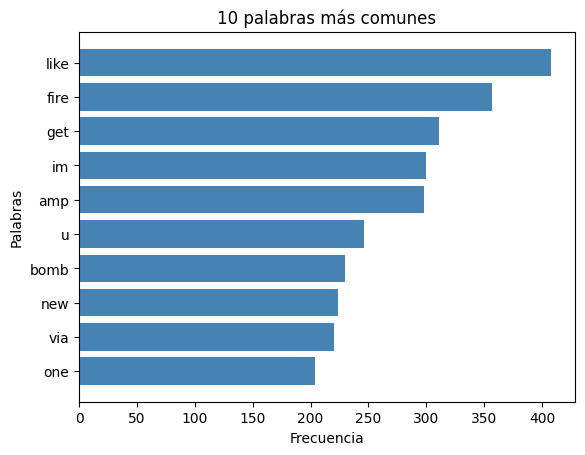

In [34]:
text = ' '.join(data_frame['text'])

# Asumiendo que 'text' es tu texto
words = text.split()
word_freq = Counter(words)

# Ahora selecciona las 10 palabras más comunes
common_words = word_freq.most_common(10)

# Desempaqueta las palabras y sus frecuencias en dos listas
words, frequencies = zip(*common_words)

# Ahora crea el histograma
plt.barh(words, frequencies, color='steelblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('10 palabras más comunes')
plt.gca().invert_yaxis()  # Esto es para invertir el eje y, para que las palabras más comunes aparezcan en la parte superior
plt.show()

#### => Discutir sobre las palabras que tienen presencia en todas las categorías.

Como se puede observar se utiliza un monton las palabras como "like", "get", "fire", "new", "one" y "bomb". Estas palabras en especifico se pueden prestar para varios contextos y escenarios, porque fuego no solamente se puede referir a incendios, sino talvez que hay un producto que anda arrasando en ventas, o aveces que hay personas que estan sobresaliendo y utilizan "fire" para hacer referencia a la recha o algo que esta "potente" al igual que "bomb". Mientras que las palabras como "like", "new" o "one" se puede prestar para muchos contextos y hasta inclusive en cualquiera de los dos escenarios. Sin embargo para esta practica se pudo ver la importancia de poder clasificar y darle un mejor contexto a los tweets que uno ingiere, ya que esto puede ser interpretado de diferentes maneras.

Se puede apreciar como es que las palabras en noticias de desastres reales y no reales cambian demasiado, en los desastres reales se obtienen palabras más serias y destructivas, mientras con los desastres no reales hay palabras muy diversas pero la mayoría son amigables y dan un contexto completamente diferente.

#### => Determinar las palabras positivas, negativas o neutras.

In [35]:
def classify_emotions(texto):
    analysis = TextBlob(texto)
    if analysis.sentiment.polarity > 0:
        return "Positivo"
    elif analysis.sentiment.polarity < 0:
        return "Negativo"
    
    return "Neutral"

In [36]:
data_frame["feeling"] = data_frame["text"].apply(classify_emotions)
data_frame[["feeling", "text"]]

,feeling,text
0,Neutral,deed reason earthquak may allah forgiv u
1,Positivo,forest fire near la rong sask canada
2,Neutral,resid ask shelter place notifi offic evacu she...
3,Neutral,13000 peopl receiv wildfir evacu order california
4,Neutral,got sent photo rubi alaska smoke wildfir pour ...
...,...,...
7608,Neutral,two giant crane hold bridg collaps nearbi home
7609,Positivo,aria_ahrari thetawniest control wild fire cali...
7610,Neutral,m194 0104 utc5km volcano hawaii
7611,Neutral,polic investig ebik collid car littl portug eb...


#### 6. Teniendo en cuenta la cantidad de palabras positivas y negativas del tweet determine qué tan positivo, negativo o neutral es el mismo.

In [37]:
afinn = Afinn()
data_frame['text_feeling'] = data_frame['text'].apply(afinn.score)

In [38]:
data_frame['text_feeling']

0       0.0
1      -2.0
2       0.0
3       0.0
4       0.0
       ... 
7608    0.0
7609   -2.0
7610    0.0
7611   -4.0
7612    0.0
Name: text_feeling, Length: 7613, dtype: float64

#### 7. Luego de analizar los datos determine.

#### => 7.1 ¿Cuáles son los 10 tweets más negativos?¿En qué categoría están?

In [39]:
data_frame.sort_values('text_feeling', ascending=False).tail(10)

,id,keyword,location,text,target,feeling,text_feeling
3609,5152,fatal,NaN,news crime polic id victim fatal crash close i...,1,Positivo,-11.0
6814,9761,trapped,call me peach or sam lo,im trap damn ga pump two suv either side fuck ...,0,Negativo,-11.0
3742,5319,fire,2 high 2 come down,miss_homasttopa caus fire fire fire yeah fire ...,1,Neutral,-11.0
2932,4213,drowned,Pembroke NH,lake see dead fish poor littl guy wonder happe...,0,Negativo,-11.0
4199,5962,hazard,scandinavia,decemb 2011 court dismiss group charg rape vic...,0,Negativo,-11.0
4794,6820,loud%20bang,Aperture Science Test Facility,fuck loud bang flash light outsid im pretti su...,0,Positivo,-11.0
5430,7749,police,NaN,fuck polic cant touch fuck nigga aint fuck w,0,Negativo,-12.0
409,589,arson,NaN,tennesse lesbian coupl fake hate crime destroy...,1,Negativo,-12.0
6980,10011,twister,Everywhere,stop fuck say ûïa whole ûnotherû sound fuck st...,0,Negativo,-19.0
7472,10689,wreck,NaN,wreck wreck wreck wreck wreck wreck wreck wrec...,0,Neutral,-26.0


#### => 7.2 ¿Cuáles son los 10 tweets más positivos? ¿En qué categoría están?

In [40]:
data_frame.sort_values('text_feeling', ascending=False).head(10)

,id,keyword,location,text,target,feeling,text_feeling
6992,10028,twister,NaN,check want twister ticket vip experi see shani...,0,Positivo,14.0
3163,4541,emergency,"Renfrew, Scotland",batfanuk enjoy show today great fun emerg non ...,0,Positivo,13.0
3382,4844,evacuation,"Renfrew, Scotland",batfanuk enjoy show today great fun emerg non ...,0,Positivo,13.0
5033,7176,mudslide,London,first impress glad hat man leav lieu interest ...,0,Positivo,13.0
6292,8989,storm,NaN,todayûª storm pas let tomorrowûª light greet k...,1,Positivo,11.0
4710,6697,landslide,NaN,morning_jo reinc presssec joe ur smart u run 4...,0,Positivo,11.0
1001,1453,body%20bagging,NaN,im drake fan enjoy see bodybag peopl great mar...,0,Positivo,11.0
7291,10432,whirlwind,"brooklyn, NYC",picthi ûó iûªm thank much toronto whirlwind am...,0,Positivo,9.0
945,1369,blown%20up,LA/OC/Vegas,princessduck last week want 6th sen get blown ...,0,Positivo,9.0
132,191,aftershock,NaN,aftershock back school kick great want thank e...,0,Positivo,9.0


#### => 7.3 ¿Son los tweets de la categoría que indica que habla de un desastre real más negativos que los de la otra categoría?

En efecto que sí, como se puede apreciar que se toman twits muy serios, mientras más el punteo negativo de text_feeling sea la noticia es más negativa. Pero igual se puede apreciar que el clasificador de sentimientos encuentra notificar que se cliasificaban como no desastres pero suelen representar varias sentimientos negativos y otros decian que no son desastres pero si son desastres.

#### 8. Cree una variable que contenga la “negatividad” de cada tweet. Inclúyala en el conjunto de datos y entrene nuevamente el modelo de clasificación de la hoja pasada. ¿La inclusión de esta variable mejoró los resultados del modelo de clasificación?

In [41]:
X = np.column_stack((X.toarray(), data_frame['text_feeling']))  # Combina las características n-gram y text_feeling
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75)

In [42]:
best_accuracy = 0
best_c = None
for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    accuracy = accuracy_score(y_val, svm.predict(X_val))
    print ("Accuracy for C=%s: %s" % (c, accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_c = c

model_svm = LinearSVC(C=best_c).fit(X, y)

d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for C=0.001: 0.7263655462184874


d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for C=0.005: 0.7909663865546218


d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for C=0.01: 0.7998949579831933


d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for C=0.05: 0.8061974789915967


d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy for C=0.1: 0.8046218487394958


d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [43]:
final_svm = LinearSVC(C=best_c)
final_svm.fit(X, y)
print ("Final Accuracy: %s" % accuracy_score(y, final_svm.predict(X)))

d:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Final Accuracy: 0.9801655063706818


Como se puede apreciar se obtuvo un accurracy mucho mejor que el modelo anterior. En resumen la inclusión de esta variable mejoro los resultados.